**import required libraries**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

**Load dataset and Convert dates to datetime**

In [7]:

df = pd.read_csv('insurance_revenue_leakage_data.csv')


df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])
df['last_claim_date'] = pd.to_datetime(df['last_claim_date'])

**Feature engineering**

In [28]:

current_date = pd.Timestamp('2023-12-31')
df['policy_age_years'] = (current_date - df['policy_start_date']).dt.days // 365
# Handle NaT values safely
df['days_since_last_claim'] = np.where(
    df['last_claim_date'].notna(),
    (current_date - df['last_claim_date']).dt.days,
    np.nan
)
# Safe division with zero handling
df['premium_per_claim'] = np.divide(
    df['premium_amount'],
    df['total_claims'],
    where=(df['total_claims'] > 0),
    out=np.zeros_like(df['premium_amount'], dtype=float)
)    
    
df['claim_frequency'] = np.divide(
    df['total_claims'],
    df['policy_age_years'] + 1,
    where=(df['policy_age_years'] >= 0),
    out=np.zeros_like(df['total_claims'], dtype=float)
)  # +1 to avoid division by zero

df['age_group'] = pd.cut(df['customer_age'], 
                       bins=[17, 30, 45, 60, 80], 
                       labels=['18-30', '31-45', '46-60', '61-80'],right=False)

# Clean infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

**Define features and target**

In [29]:

X = df.drop(['policy_id', 'policy_start_date', 'last_claim_date', 'revenue_leakage_flag'], axis=1)
y = df['revenue_leakage_flag']


**Preprocessing pipeline**

In [30]:

numeric_features = [
    'premium_amount', 'policy_tenure', 'total_claims', 'avg_claim_amount',
    'discount_rate', 'outstanding_balance', 'payment_delay_days',
    'underwriting_errors', 'claim_processing_days', 'customer_age',
    'policy_age_years', 'days_since_last_claim', 'premium_per_claim',
    'claim_frequency'
]

categorical_features = ['coverage_type', 'region', 'customer_segment', 'age_group']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

**Split data**

In [31]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

**Build model pipeline**

In [32]:

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1))])

**Hyperparameter tuning**

In [33]:

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [5, 10],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

**Evaluate model**

Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1905
           1       0.00      0.00      0.00        95

    accuracy                           0.95      2000
   macro avg       0.48      0.50      0.49      2000
weighted avg       0.91      0.95      0.93      2000

ROC AUC Score: 0.5383616521619008


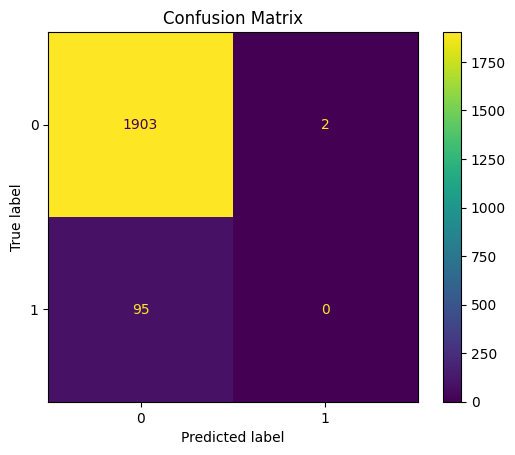

In [34]:

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

**Feature importance analysis**

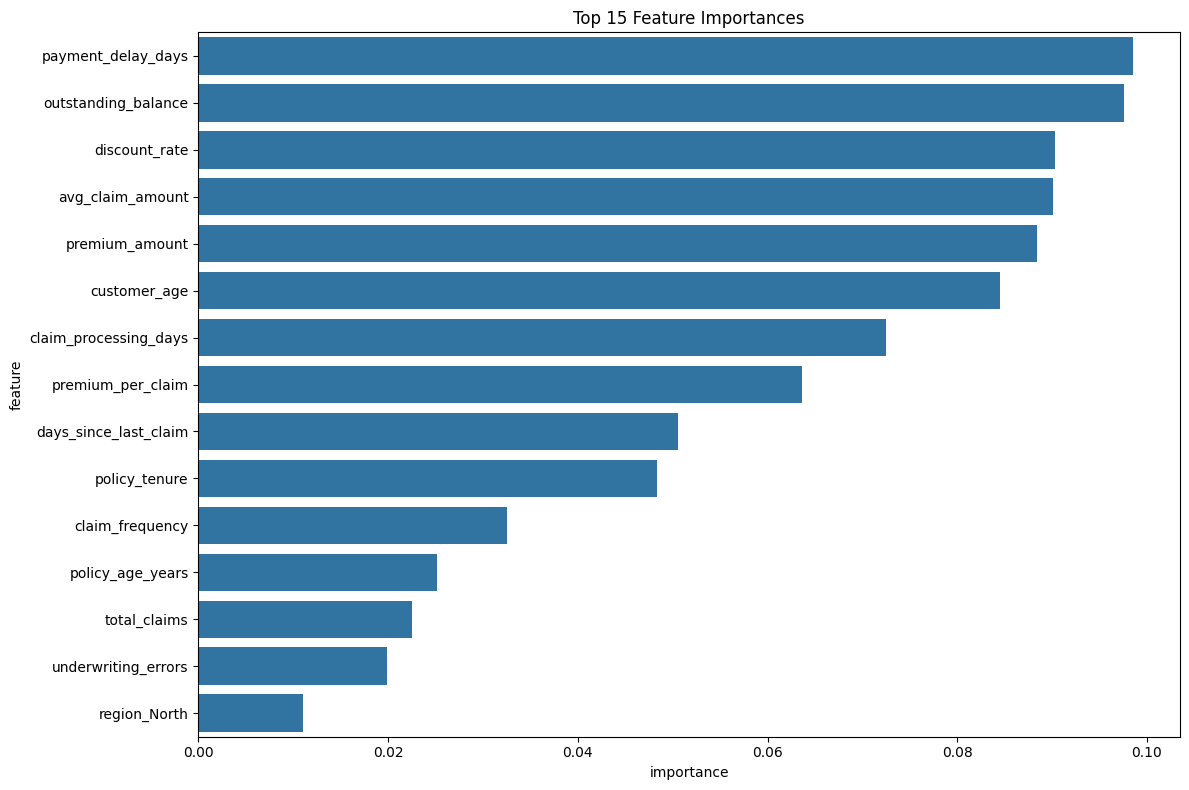

In [35]:

feature_names = numeric_features + list(
    best_model.named_steps['preprocessor'].named_transformers_['cat']
    .named_steps['onehot'].get_feature_names_out(categorical_features))

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

**Financial impact analysis**

In [36]:

leakage_cases = X_test[y_pred == 1].copy()
leakage_cases['predicted_probability'] = y_proba[y_pred == 1]

# Calculate estimated leakage amount (example calculation)
leakage_cases['estimated_leakage'] = (
    leakage_cases['avg_claim_amount'] * 0.7 -  # Assuming 70% of claim amount is recoverable
    leakage_cases['premium_amount'] * 
    (1 - leakage_cases['discount_rate'])
)

print(f"Total Predicted Annual Leakage: ${leakage_cases['estimated_leakage'].sum():,.2f}")
print("\nTop 10 High-Impact Leakage Cases:")
print(leakage_cases.sort_values('estimated_leakage', ascending=False).head(10))

Total Predicted Annual Leakage: $4,834.08

Top 10 High-Impact Leakage Cases:
      premium_amount  coverage_type  policy_tenure  total_claims  \
8400     4175.104177  Comprehensive             10             2   
286      5907.920817  Comprehensive              7             2   

      avg_claim_amount  discount_rate  outstanding_balance  \
8400       9934.120252       0.243270           387.886041   
286        7987.553829       0.229566           110.831113   

      payment_delay_days  underwriting_errors  claim_processing_days  ...  \
8400           27.299942                    1                     32  ...   
286             7.567036                    0                     26  ...   

      policy_age_years  days_since_last_claim premium_per_claim  \
8400                 0                    NaN       2087.552089   
286                  1                    NaN       2953.960408   

     claim_frequency  age_group  leakage_probability  predicted_leakage  \
8400             2.0  

**Export the result to CSV**

In [37]:
# Generate predictions and probabilities USING THE PIPELINE
df['leakage_probability'] = best_model.predict_proba(X)[:, 1]
df['predicted_leakage'] = best_model.predict(X)

# Calculate financial impact
df['estimated_leakage_amount'] = (
    (df['avg_claim_amount'] * 0.7) -  # Assumed recoverable percentage
    (df['premium_amount'] * (1 - df['discount_rate']))
).where(df['predicted_leakage'] == 1, 0)

# Export for Power BI
df.to_csv('leakage_analysis_results.csv', index=False)

In [38]:
# Get feature importance after model training
feature_importance = pd.DataFrame({
    'feature': feature_names,  # From previous code
    'importance': best_model.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

# Create a formatted version for Power BI
feature_importance['importance_percent'] = (feature_importance['importance'] * 100).round(2)
feature_importance['feature_category'] = np.where(
    feature_importance['feature'].isin(numeric_features), 
    'Numeric', 
    'Categorical'
)

# Export to separate CSV
feature_importance.to_csv('feature_importance_scores.csv', index=False)